In [2]:
using Slepians, FFTW, Plots, LinearAlgebra, Arpack

# Some to do's:
- add a struct that has a plots recipe that will plot time/frequency domain versions

In [8]:
function pad(x::Vector, M::Int64)
    vcat(x, zeros(M - length(x)))
end

function seq_to_fun(x, M)
    fft(pad(x, M))
end

In [1]:
using RecipesBase
struct Slepian
    t::Union{LinRange{Float64,Int64},Vector{Float64}}
    x::Vector{Float64}
end

t = LinRange(0,1.0,101)[1:100]
x = randn(100)
Slepian(t,x)

Slepian(LinRange{Float64}(0.0, 0.99, 100), [0.29194918713675505, 0.12617334723072138, -0.07466001683145185, 0.4333681167942882, 1.1236757063677916, 1.5854377577996266, -1.4364436343009328, -0.6085342908077889, 0.08891569477634693, 0.04971050699779857  …  -1.27989986946086, -2.6486035151949046, 0.6561428167904385, -1.043505942165807, 0.20368975537709197, 1.1454004876182202, 1.4890772305342868, 2.399220728380706, -1.0554740437167471, -0.059500662943587815])

In [ ]:
@recipe function plot(S::Slepian ; ) 
    yscale --> :log10
    N = length(x)
    M = 2*N
    freq = LinRange(0,1.0,M+1)[1:M]
    xlab = "Frequency" 
    ylab = "Magnitude Squared FFT"
    @series begin
        freq, abs2.(fft(pad(x, M)))
    end 
end





# Slepian functions using Gauss-Legendre quadrature

Begin by setting up the parameters. We'll use N = 1024 for a nice FFT. 

In [3]:
N     = 1024
NW    = 4.0 
K     = 8
W = NW/N

0.00390625

## Start the Quadrature

Using the FastGaussQuadrature package for the nodes and weights, we proceed as in Simons and Wang, 2011. The eigenvalue problem is equations (8a-b):

$$ \int_{-1}^{1} D(x, x')\psi(x')dx' = \lambda \psi(x), $$

$$ D(x, x') = \frac{\sin N W (x - x')}{\pi (x-x')} $$

So we set up the function `kernel` to evaluate $D(x - x')$.

In [4]:
using FastGaussQuadrature, Base, SpecialFunctions

no, wt = gausslegendre(100) 

# This is equation 8b in Simons and Wang 2011
function kernel(no, NW) 
    return (NW/pi) * sinc.( NW * no)
end

kernel (generic function with 1 method)

# Formulation

Now we use the quadrature rule (Equations (82-84) in Simons and Wang). Letting $x_i$ denote the quadrature nodes, write

$$ \sum_{j=1}^{J}  w_j D(x_i, x_j) f(x_j) = \lambda f(x_i) $$

or, in vector notation 

$$ D W f = \lambda f $$

where $D_{i,j} = D(x_i, x_j)$, $f_j = f(x_j)$ and $W$ is a diagonal matrix with the weights on the diagonal.

Reformulating, we actually solve

$$ \tilde{W} D \tilde{W} \tilde{f} = \lambda \tilde{f} $$

where $\tilde{W}$ has  $\sqrt{w}$ on its diagonal, and then return to the f's using $f_i = \sqrt{w_i} f_i$.  

In [5]:
Wtilde = diagm(sqrt.(wt))

100×100 Matrix{Float64}:
 0.0271041  0.0        0.0        …  0.0        0.0        0.0
 0.0        0.0413448  0.0           0.0        0.0        0.0
 0.0        0.0        0.0518066     0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0        …  0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0        …  0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0           0.0        0.0        0.0
 ⋮                                ⋱                        
 0.0        0.0        0.0           0.0        0.0        0.0
 0.0        0.0        0.0       

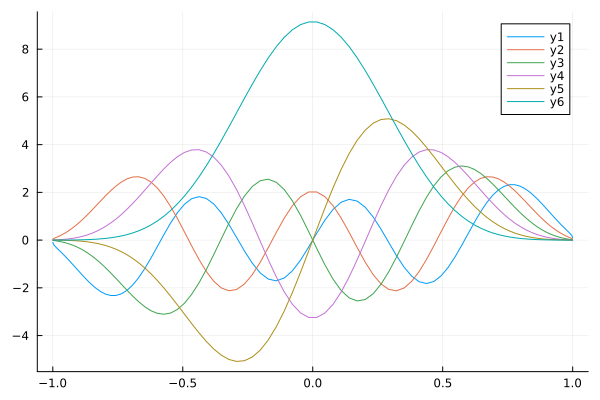

In [6]:
lam, ftilde = eigen(Wtilde * kernel(no .- no', NW) * Wtilde)

f = real.(ftilde) * diagm(1.0 ./ sqrt.(wt))

# We get the 1D Slepians at the quadrature nodes
a = plot(no, f[:, 95:100])

## Get evenly spaced Slepians

Substitute into 
$$ \sum_{j=1}^{J}  w_j D(y_i, x_j) f(x_j) = \lambda f(y_i) $$

where the $y_i$'s are evenly spaced points

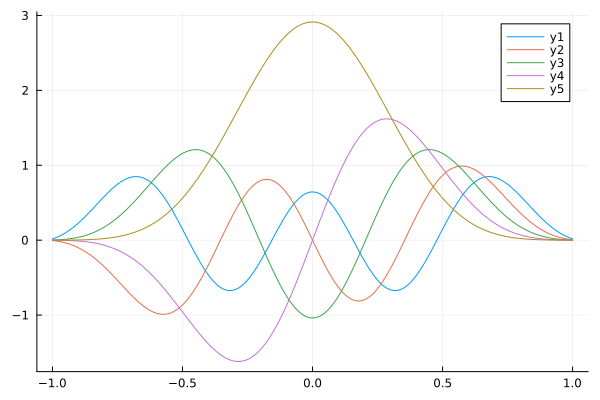

In [7]:
y = LinRange(-1, 1.0, N)
Deve = kernel(y .- no', NW)
feve = Deve * diagm(wt) * f

plot(y, real.(feve[:,(end-4):end]))

The last few eigenvalues are large. 

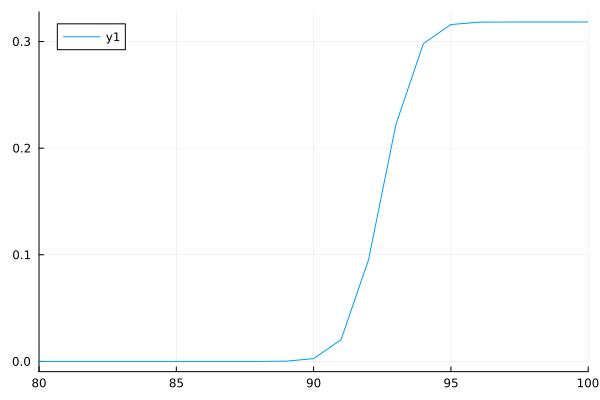

In [18]:
plot(real.(lam), xlim=[80, 100])

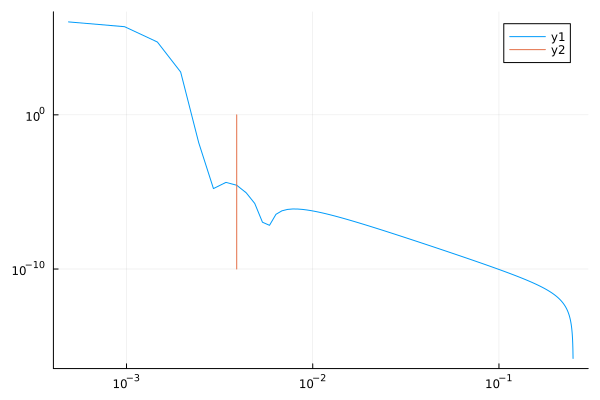

In [28]:
plot(LinRange(0,0.5,1025)[2:513], abs2.(fft(feve[:,end]))[1:512], xscale = :log10, yscale = :log10)
plot!(W*ones(2),[1e-10,1])

# Discrete prolate spheroidal sequences

The discrete prolate spheroidal sequences (Slepian, 1978), $v_n^{(k)}(N,W)$, are the eigenvector solutions to the eigenvalue problem

$$\sum_{m = 0}^{N-1}\frac{\sin 2\pi W(n-m)}{\pi(n-m)}v_m^{(k)}(N,W) = \lambda_k(N,W)\cdot v_n^{(k)}(N,W)$$

where $N$ is the length of the sequence, $n = 0, \ldots, N-1$, $W$ is the bandwidth, $K$ is the number of tapers, and $\lambda_k(N,W)$ is the eigenvalue corresponding to the $k$th taper. 

The dpss's solve the problem of concentrating, in frequency, the most amount of mass under the interval $(-W,W)$, while having only finite extent in time. 

In Slepians.jl, the dpss's are computed in the following way.

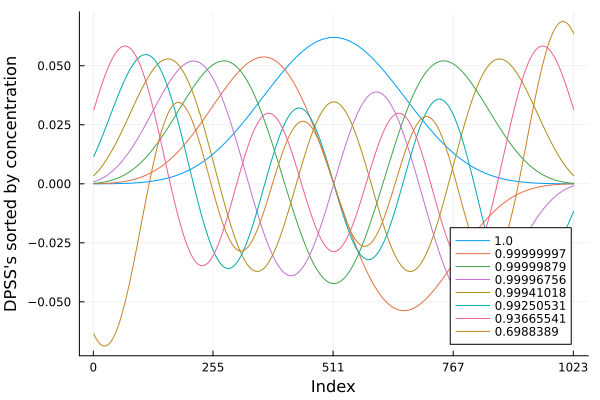

In [3]:
v,lam = dpss_tapers(N, NW, K, :both)

p1 = plot(v, label = round.(lam', digits=8), xlabel = "Index", 
    ylabel = "DPSS's sorted by concentration",
    xtick=([1,256,512,768,1024].-1))

The very first dpss taper has the largest "concentration" in the bandwidth of interest, very close to one. Subsequent tapers are less and less concentrated. To see this, plot their Fourier transforms as below. We zero pad, as before, to interpolate structure in frequency.

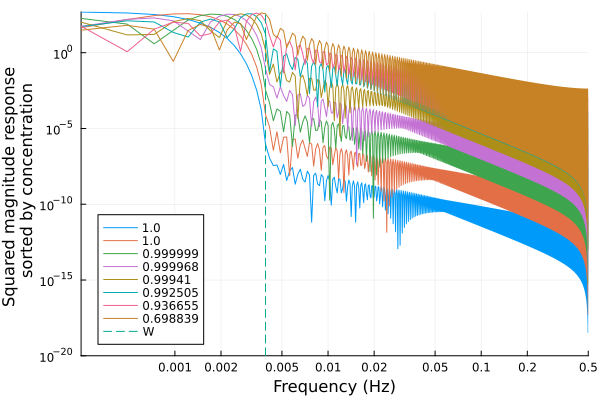

In [4]:
M        = 4*N
halffreq = Int64(M/2-1)
U        = mapreduce(x -> abs2.(seq_to_fun(x, M)[2:halffreq,:]), hcat, v[:,k] for k in 1:K)
freq     = range(0, 1,length = M+1)[2:halffreq]

p2 = plot(freq, U, 
    label = round.(lam', digits=6), yscale = :log10, 
    xscale = :log10, xlims = [freq[1], freq[end]],
    xlabel = "Frequency (Hz)", 
    #title = "Slepian sequences",
    ylabel = "Squared magnitude response \n sorted by concentration",
    legend = :bottomleft, ylims =[1e-20,500],
    xtick=([1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1,2e-1,5e-1],["0.001","0.002","0.005","0.01","0.02","0.05","0.1","0.2","0.5"])
)

plot!(p2, (NW/N)*ones(2), [1e-30, 1e3], label="W", line = :dash)

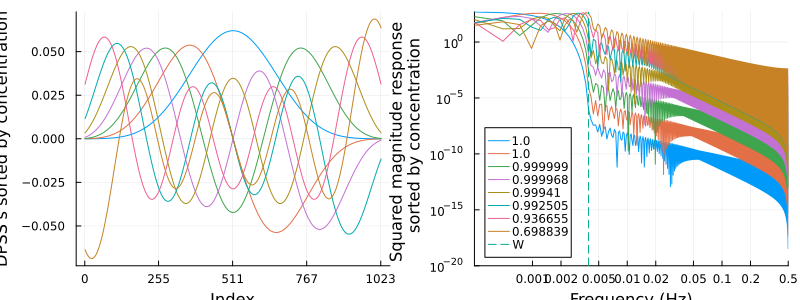

In [5]:
plot!(p1,legend=false)
plot(p1, p2, size = [800,300])

One can see that the bulk of the mass under each of the curves is on the interval (-W,W). 
It is also easy to see that as the concentration, lambda, decreases, there is less mass under
the curve inside the band. Since the sequences all have unit energy, there is more mass outside
the band for larger index. Comparing with the tapers in the first plot, we see the power drop off rather quickly outside the band (-W, W) of interest. 

The bandwidth, $W$, is a tuning parameter for the multitaper method, and one adjusts the bandwidth by selecting the time-bandwidth product <tt>NW</tt> above. The number of tapers, $K$, is selected to be less than $2NW$, as the concentration rapidly drops with increasing $k$. For further reading, consult the original paper cited below. 

# References

Slepian, David. "Prolate spheroidal wave functions, Fourier analysis, and uncertainty—V: The discrete case." Bell System Technical Journal 57.5 (1978): 1371-1430.

In [6]:
plot!(p1, legend=false, size = [400,300])
savefig(p1, "../paper/figures/Dpss_time.pdf")

"/Users/chaley/Documents/Repos/Slepians.jl/paper/figures/Dpss_time.pdf"

In [7]:
plot!(p2, size = [400,300], ylims = [1e-15,500],
xtick=([1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1,2e-1,5e-1],["0.001","","","0.01","","","0.1","","0.5"])
)
savefig(p2,"../paper/figures/Dpss_freq.pdf")

"/Users/chaley/Documents/Repos/Slepians.jl/paper/figures/Dpss_freq.pdf"

In [8]:
println(lam)

[0.9999999997055655, 0.9999999723286904, 0.9999987902597983, 0.9999675626064185, 0.9994101803915634, 0.9925053051987771, 0.93665540820723, 0.6988389018033373]


## Example - Durrani-Chapman

If one constrains to the following all-pole form for the magnitude response of a digital filter
$$ |H(f)|^2 = \frac{1}{1+\left| \sum_{j=1}^{N} \beta_k e^{i 2 pi f j} \right |^2} $$
Then as Durrani and Chapman showed, the coefficients $\beta_j$ is the $N$th (i.e. smallest) scaled discrete prolate spheroidal sequence, where the scaling factor is chosen so that the filter has its half power point at the chosen cutoff frequency $f_0$. Below, we recreate figures 1-3 from the example in the paper cited.

To begin, we alter the DPSS code so that it returns the Slepian sequence associated with the smallest eigenvalue instead of the largest ones.

In [9]:
function dpss_matrix(nw, n)
    SymTridiagonal([cos(2*pi*(nw/n))*abs2(0.5*(n-1)-(j-1)) for j in 1:n],
                          [0.5*j*(n-j) for j in 1:(n-1)])
end

"""
    dpss_smallest(n, nw)

Computes the dpss associated with the smallest eigenvalue, normalized so that the first entry is 1.0.
"""
function dpss_smallest(n, nw) 
  stdm = dpss_matrix(nw, n)
  theta = eigvals(stdm, 1:1)
  vv = eigvecs(stdm, theta)
  return vv./vv[1]
end

dpss_smallest

In order to recreate Figs. 1 and 3, we use the following parameters, and we get the following matrix $\sigma$

In [10]:
N = 4
NW = 0.1*N

sigma = dpss_matrix(NW, N)

4×4 SymTridiagonal{Float64, Vector{Float64}}:
 1.82029  1.5        ⋅         ⋅ 
 1.5      0.202254  2.0        ⋅ 
  ⋅       2.0       0.202254  1.5
  ⋅        ⋅        1.5       1.82029

We then obtain the dpss associated with the smallest eigenvalue, and normalize the vector so that the first entry is 1.0.

Scaled eigenvector [1.0; -2.772684022612469; 2.772684022612469; -1.0;;]
Eigenvalue [-2.3387377965750717]


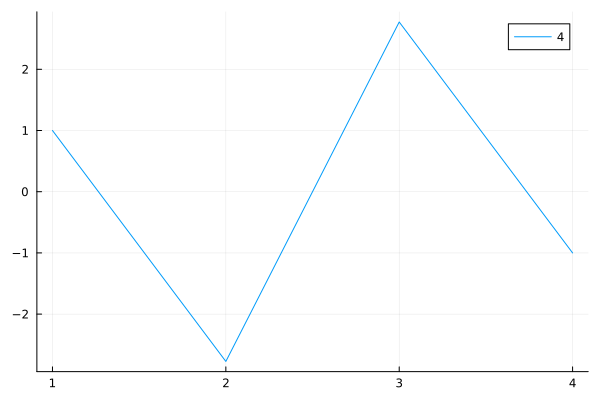

In [11]:
vmin = dpss_smallest(N, NW)
println("Scaled eigenvector $(vmin)")
println("Eigenvalue $(eigvals(sigma, 1:1))")
plot(vmin, label = N)

We want to choose the constant $K$ so that $|H(f_0)|^2$ is 3 db down from $|H(0)|^2$
or
$$ K = \frac{1}{(|\phi(f_0)|^2 - 2|\phi(0)|^2)}$$
meanwhile, $K=\beta^T\beta$.

In [12]:
# Find the scaling factor
K = (1.0 ./ (abs2.(exp.(-2*pi*1im*0.1*collect(1:N)')*vmin) - 2*abs2.(exp.(-2*pi*1im*0.0*collect(1:N)')*vmin)))[1,1]
beta = vmin * sqrt(K)

# Compute the transfer function
freq = LinRange(-0.5, 0.5, M+1)[1:M]
Hf = 1.0 ./ (1 .+ abs2.(exp.(-2*pi*1im*freq*collect(1:length(vmin))')*beta))

beta

4×1 Matrix{Float64}:
  10.462551790888837
 -29.009350186352954
  29.009350186352954
 -10.462551790888837

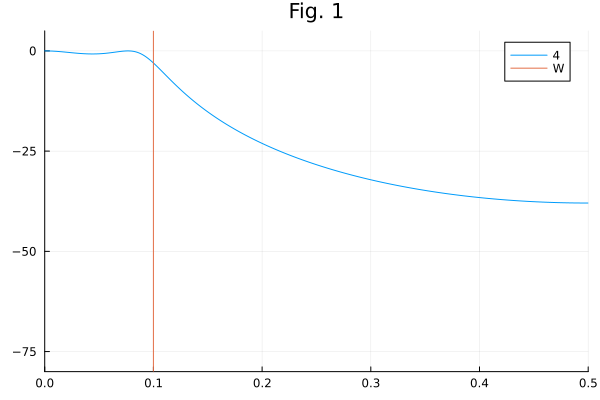

In [13]:
# Fig 1
p1 = plot(freq, 10*log10.(Hf), xlims=[0,0.5], label = N', ytick = -75:25:0, ylims = [-80,5], title = "Fig. 1")
plot!(p1, [1,1]*0.1, [-80,5], label = "W")


In [14]:
function durranichapman_coeff(N, NW)
    vmin = dpss_smallest(N, NW)
    f0 = NW/N
    K = (1.0 / (abs2.(exp.(-2 * pi * 1.0im * f0 * collect(1:N)') * vmin)[1, 1] - 2 * abs2.(sum(vmin))))
    return vmin * sqrt(K)
end

function transfn(beta, M)
    # Compute the transfer function
    N = length(beta)
    freq = LinRange(-0.5, 0.5, M + 1)[1:M]
    Hf = 1.0 ./ (1 .+ abs2.(exp.(-2 * pi * 1im * freq * collect(1:N)') * beta))
    return Hf
end

transfn (generic function with 1 method)

In [15]:
N = 4:2:10
NW = 0.1*N

beta = [durranichapman_coeff(N[i], NW[i]) for i in 1:4]
Hf = hcat([transfn(beta[i], M) for i in 1:4]...)

beta[1]

4×1 Matrix{Float64}:
  10.462551790888837
 -29.009350186352954
  29.009350186352954
 -10.462551790888837

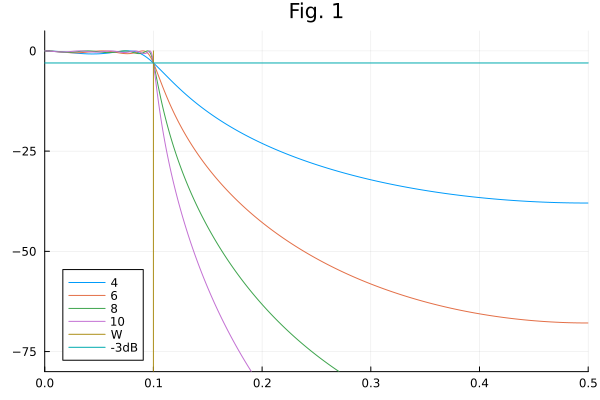

In [16]:
# Fig 1
p1 = plot(freq, 10*log10.(Hf), xlims=[0,0.5], label = N', ytick = -75:25:0, ylims = [-80,5], title = "Fig. 1")
plot!(p1, [1,1]*0.1, 10*log10.([minimum(Hf), maximum(Hf)]), label = "W")
plot!(p1, [0,0.5],[1,1]*-3, label = "-3dB")

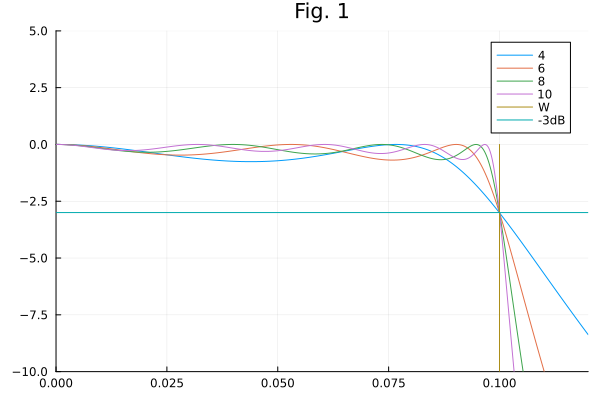

In [17]:
plot!(p1, xlims=[0,0.12], ylims = [-10,5], ytick = -10:2.5:5 )

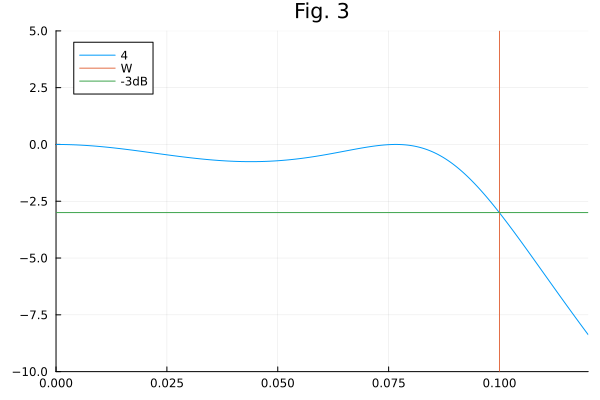

In [18]:
# Fig 3
plot(freq, 10*log10.(Hf[:,1]), xlims=[0,0.12], ytick = -10:2.5:5, ylims = [-10,5], label = N[1], title = "Fig. 3")
plot!([1,1]*0.1, [-10,5], label = "W")
plot!([0,0.12],[1,1]*-3, label = "-3dB")

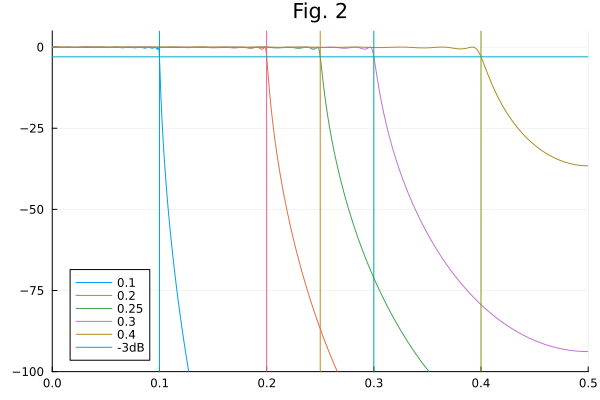

In [19]:
f0 = [0.1, 0.2, 0.25, 0.3, 0.4]
N = 20
NW = f0*N

beta = [durranichapman_coeff(N, NW[i]) for i in 1:length(f0)]
Hf = hcat([transfn(beta[i], M) for i in 1:length(f0)]...)

# Fig 2
plot(freq, 10*log10.(Hf), xlims=[0,0.5], label = f0', ytick = -150:25:0, ylims = [-100,5], title = "Fig. 2")
plot!([1.,1] * f0', [-100,5], label = "")
plot!([0,0.5],[1,1]*-3, label = "-3dB")

## Reference
Durrani, T., and R. Chapman. "Optimal all-pole filter design based on discrete prolate spheroidal sequences." IEEE transactions on acoustics, speech, and signal processing 32.4 (1984): 716-721.